In [2]:
from __future__ import annotations
from pathlib import Path
from typing import Optional, Union, Sequence
import json

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    top_k_accuracy_score,
)

def _load_labels(labels_path: Union[str, Path]) -> Optional[list[str]]:
    p = Path(labels_path)
    if not p.exists():
        return None
    with p.open() as f:
        obj = json.load(f)
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        return [obj[str(i)] for i in range(len(obj))]
    return None

@torch.no_grad()
def predict_logits_from_checkpoint(
    model_cls,
    ckpt_path: Union[str, Path],
    x: torch.Tensor,
    y: Optional[torch.Tensor] = None,
    batch_size: int = 64,
    device: Optional[torch.device] = None,
    labels_path: Optional[Union[str, Path]] = None,
    strict: bool = True,
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ckpt = torch.load(Path(ckpt_path), map_location="cpu")
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        state_dict = ckpt["model_state"]
        hp = ckpt.get("hp", {})
    else:
        state_dict, hp = ckpt, {}

    class_names = _load_labels(labels_path) if labels_path else None
    n_classes = len(class_names) if class_names is not None else (int(torch.max(y).item()) + 1 if y is not None else None)
    if n_classes is None:
        raise ValueError("Need either labels_path or y to infer n_classes.")

    model = model_cls(
        n_classes=n_classes,
        d_model=int(hp.get("d_model", 64)) if isinstance(hp, dict) else 64,
        n_heads=int(hp.get("n_heads", 2)) if isinstance(hp, dict) else 2,
        n_layers=int(hp.get("n_layers", 1)) if isinstance(hp, dict) else 1,
    ).to(device)

    model.load_state_dict(state_dict, strict=strict)
    model.eval()

    ds = TensorDataset(x, torch.zeros(len(x), dtype=torch.long) if y is None else y)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    logits_list = []
    y_list = []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        logits_list.append(logits.cpu())
        y_list.append(yb.cpu())

    logits_all = torch.cat(logits_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    return logits_all, y_all, class_names

def evaluate_basic(
    logits: torch.Tensor,
    y_true: torch.Tensor,
    class_names: Optional[Sequence[str]] = None,
    topk: tuple[int, ...] = (1, 3, 5),
):
    probs = torch.softmax(logits, dim=1).numpy()
    y = y_true.numpy()
    y_pred = probs.argmax(axis=1)

    out = {}
    out["acc"] = float(accuracy_score(y, y_pred))

    for k in topk:
        out[f"top{k}_acc"] = float(top_k_accuracy_score(y, probs, k=k, labels=np.arange(probs.shape[1])))

    # macro/weighted scores + per-class table
    report = classification_report(
        y, y_pred,
        target_names=list(class_names) if class_names is not None else None,
        digits=4,
        output_dict=True,
        zero_division=0,
    )
    out["macro_f1"] = float(report["macro avg"]["f1-score"])
    out["weighted_f1"] = float(report["weighted avg"]["f1-score"])
    return out, report, y_pred


In [4]:
from call_of_birds_autobird.model import Model
from call_of_func.train.train_helper import _get_device

root = Path.cwd().parent
device = _get_device(local_rank=0)

test_x = torch.load(root / "data" / "processed" / "val_x.pt")
test_y = torch.load(root / "data" / "processed" / "val_y.pt")

logits, y_true, class_names = predict_logits_from_checkpoint(
    model_cls=Model,
    ckpt_path=root / "models" / "checkpoints" / "best.pt",
    x=test_x,
    y=test_y,
    batch_size=32,
    device=device,
    labels_path=root / "data" / "processed" / "labels.json",
)

print(len(class_names))

metrics, report, y_pred = evaluate_basic(logits, y_true, class_names=class_names)
print(metrics)
print("macro_f1:", metrics["macro_f1"], "weighted_f1:", metrics["weighted_f1"])


/Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_3/project/mlops_project/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


91
{'acc': 0.7678680513133781, 'top1_acc': 0.7678680513133781, 'top3_acc': 0.8081857055589493, 'top5_acc': 0.8362858888210141, 'macro_f1': 0.5144660613895476, 'weighted_f1': 0.726752472156385}
macro_f1: 0.5144660613895476 weighted_f1: 0.726752472156385


In [5]:
def easiest_hardest_classes(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: Optional[Sequence[str]] = None,
    top_n: int = 10,
):
    n_classes = int(max(y_true.max(), y_pred.max())) + 1
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

    support = cm.sum(axis=1)                    # true counts per class
    correct = np.diag(cm)
    recall = np.divide(correct, support, out=np.zeros_like(correct, dtype=float), where=support != 0)

    idx_sorted = np.argsort(recall)
    hardest = idx_sorted[:top_n]
    easiest = idx_sorted[::-1][:top_n]

    def fmt(i):
        name = class_names[i] if class_names is not None else str(i)
        return f"{i:>3} | {name:<35} | recall={recall[i]:.3f} | support={support[i]}"

    print("\nHardest classes (lowest recall):")
    for i in hardest:
        print(fmt(i))

    print("\nEasiest classes (highest recall):")
    for i in easiest:
        print(fmt(i))

    return cm, recall, support


In [6]:
cm, recall, support = easiest_hardest_classes(
    y_true=y_true.numpy(),
    y_pred=y_pred,
    class_names=class_names,
    top_n=10,
)



Hardest classes (lowest recall):
 57 | Puna_Tinamou_sound                  | recall=0.000 | support=13
 20 | Chestnut-headed_Chachalaca_sound    | recall=0.000 | support=8
 21 | Chestnut-winged_Chachalaca_sound    | recall=0.000 | support=3
 43 | Huayco_Tinamou_sound                | recall=0.000 | support=7
 65 | Rufous-vented_Chachalaca_sound      | recall=0.000 | support=9
 53 | Ornate_Tinamou_sound                | recall=0.000 | support=2
 77 | Tataupa_Tinamou_sound               | recall=0.000 | support=17
 26 | Common_Ostrich_sound                | recall=0.000 | support=5
 76 | Taczanowskis_Tinamou_sound          | recall=0.000 | support=13
 28 | Darwins_Nothura_sound               | recall=0.000 | support=21

Easiest classes (highest recall):
 90 | Yellow-legged_Tinamou_sound         | recall=1.000 | support=16
 61 | Red-throated_Piping_Guan_sound      | recall=1.000 | support=21
 59 | Red-faced_Guan_sound                | recall=1.000 | support=50
 56 | Plain_Chachalaca_soun

In [7]:
def top_confusions(cm: np.ndarray, class_names: Optional[Sequence[str]] = None, top_n: int = 20):
    cm2 = cm.copy()
    np.fill_diagonal(cm2, 0)  # ignore correct ones

    pairs = []
    for true_i in range(cm2.shape[0]):
        pred_j = int(cm2[true_i].argmax())
        cnt = int(cm2[true_i, pred_j])
        if cnt > 0:
            pairs.append((cnt, true_i, pred_j))

    pairs.sort(reverse=True, key=lambda t: t[0])
    pairs = pairs[:top_n]

    for cnt, t, p in pairs:
        t_name = class_names[t] if class_names else str(t)
        p_name = class_names[p] if class_names else str(p)
        print(f"true={t:>3} {t_name:<30} -> pred={p:>3} {p_name:<30} | count={cnt}")


In [8]:
top_confusions(cm, class_names=class_names, top_n=30)


true= 39 Grey-legged_Tinamou_sound      -> pred= 13 Brazilian_Tinamou_sound        | count=14
true= 57 Puna_Tinamou_sound             -> pred=  1 Andean_Tinamou_sound           | count=12
true= 16 Buff-browed_Chachalaca_sound   -> pred= 29 Dusky-legged_Guan_sound        | count=10
true=  4 Bartletts_Tinamou_sound        -> pred= 90 Yellow-legged_Tinamou_sound    | count=8
true= 20 Chestnut-headed_Chachalaca_sound -> pred= 16 Buff-browed_Chachalaca_sound   | count=8
true= 35 Great_Spotted_Kiwi_sound       -> pred= 77 Tataupa_Tinamou_sound          | count=8
true= 40 Grey_Tinamou_sound             -> pred= 88 White-throated_Tinamou_sound   | count=8
true= 58 Quebracho_Crested_Tinamou_sound -> pred= 57 Puna_Tinamou_sound             | count=8
true= 76 Taczanowskis_Tinamou_sound     -> pred= 11 Black_Tinamou_sound            | count=8
true= 28 Darwins_Nothura_sound          -> pred= 17 Cauca_Guan_sound               | count=7
true= 50 Micronesian_Megapode_sound     -> pred= 31 Dwarf_Tinamo

In [9]:
def show_examples_by_class(
    logits: torch.Tensor,
    y_true: torch.Tensor,
    class_names: Optional[Sequence[str]] = None,
    per_class: int = 2,
):
    probs = torch.softmax(logits, dim=1).numpy()
    y = y_true.numpy()
    y_pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)

    n_classes = probs.shape[1]

    for c in range(n_classes):
        name = class_names[c] if class_names else str(c)
        idx_c = np.where(y == c)[0]
        if len(idx_c) == 0:
            continue

        correct_idx = idx_c[y_pred[idx_c] == c]
        wrong_idx = idx_c[y_pred[idx_c] != c]

        print(f"\nClass {c} | {name} | support={len(idx_c)}")

        if len(correct_idx) > 0:
            top_correct = correct_idx[np.argsort(conf[correct_idx])[::-1][:per_class]]
            print("  Most confident CORRECT:")
            for i in top_correct:
                print(f"    idx={i} pred={y_pred[i]} conf={conf[i]:.3f}")

        if len(wrong_idx) > 0:
            top_wrong = wrong_idx[np.argsort(conf[wrong_idx])[::-1][:per_class]]
            print("  Most confident WRONG:")
            for i in top_wrong:
                pred_name = class_names[y_pred[i]] if class_names else str(y_pred[i])
                print(f"    idx={i} pred={y_pred[i]} ({pred_name}) conf={conf[i]:.3f}")


In [10]:
show_examples_by_class(logits, y_true, class_names=class_names, per_class=2)



Class 0 | Andean_Guan_sound | support=9
  Most confident CORRECT:
    idx=5 pred=0 conf=0.998
    idx=4 pred=0 conf=0.996

Class 1 | Andean_Tinamou_sound | support=19
  Most confident CORRECT:
    idx=22 pred=1 conf=0.826
    idx=21 pred=1 conf=0.735
  Most confident WRONG:
    idx=26 pred=57 (Puna_Tinamou_sound) conf=0.788
    idx=24 pred=76 (Taczanowskis_Tinamou_sound) conf=0.754

Class 3 | Band-tailed_Guan_sound | support=17
  Most confident CORRECT:
    idx=31 pred=3 conf=1.000
    idx=35 pred=3 conf=1.000

Class 4 | Bartletts_Tinamou_sound | support=16
  Most confident CORRECT:
    idx=52 pred=4 conf=0.340
  Most confident WRONG:
    idx=46 pred=9 (Black-capped_Tinamou_sound) conf=0.978
    idx=54 pred=90 (Yellow-legged_Tinamou_sound) conf=0.884

Class 5 | Baudo_Guan_sound | support=9
  Most confident CORRECT:
    idx=66 pred=5 conf=0.931
    idx=67 pred=5 conf=0.798
  Most confident WRONG:
    idx=64 pred=18 (Chaco_Chachalaca_sound) conf=0.702
    idx=69 pred=45 (Little_Chachala

In [11]:
import matplotlib.pyplot as plt

def plot_cm_topn(cm: np.ndarray, class_names: Optional[Sequence[str]] = None, support: Optional[np.ndarray] = None, top_n: int = 25, title: str = "Confusion matrix (top-N)"):
    if support is None:
        support = cm.sum(axis=1)

    top_idx = np.argsort(support)[::-1][:top_n]
    cm_small = cm[np.ix_(top_idx, top_idx)]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm_small, cmap="Blues")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    if class_names is not None:
        names = [class_names[i] for i in top_idx]
        plt.xticks(range(top_n), names, rotation=90, fontsize=7)
        plt.yticks(range(top_n), names, fontsize=7)
    plt.tight_layout()
    plt.show()


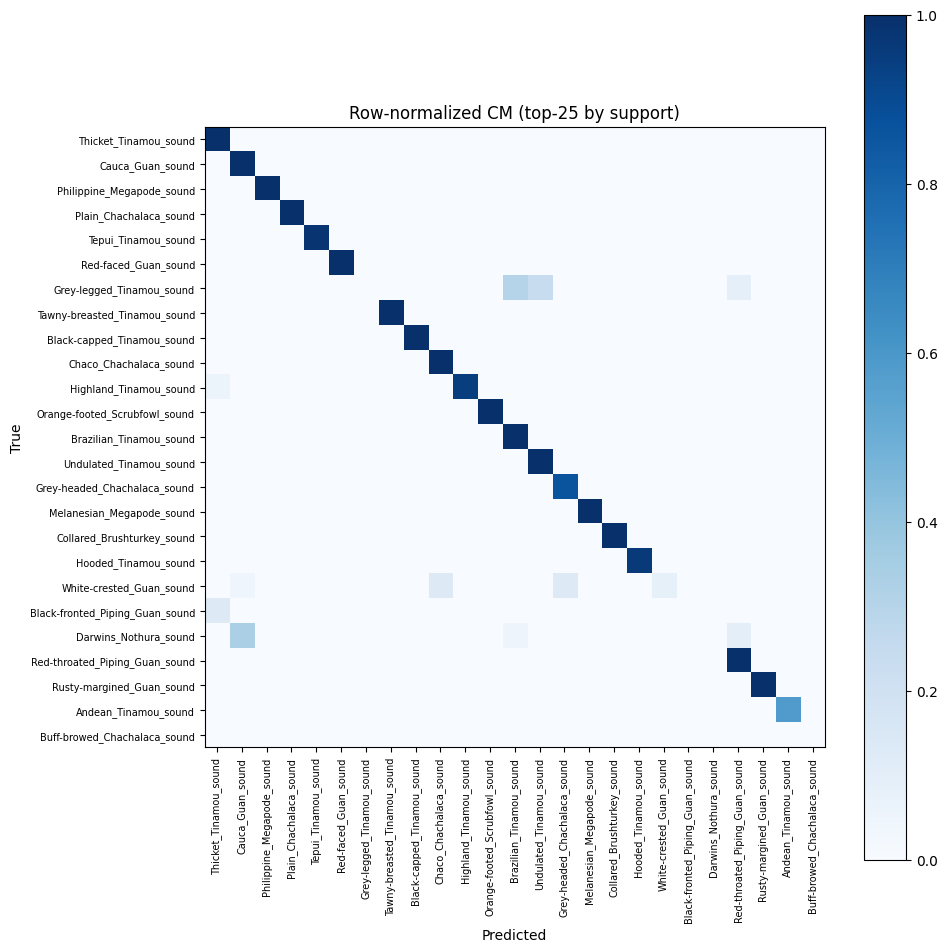

In [12]:
# row-normalize then plot top-25
cm_norm = confusion_matrix(y_true.numpy(), y_pred, labels=list(range(len(class_names))), normalize="true")
plot_cm_topn(cm_norm, class_names=class_names, support=support, top_n=25, title="Row-normalized CM (top-25 by support)")
